/Users/liting/anaconda3/envs/emcee/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Estimated alpha: Mean = 0.2666, Std = 0.2382
Estimated f0: Mean = 0.4648, Std = 0.2498
Estimated f1: Mean = 0.003494, Std = 0.006672


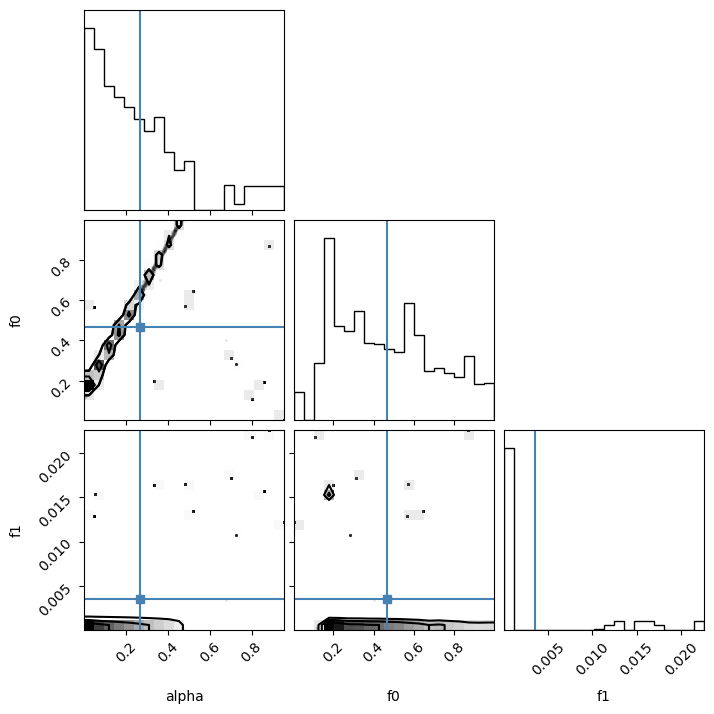

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import corner
from emcee import EnsembleSampler
import pandas as pd

# Constants and measurement uncertainties
const_s = 1370  # Solar radiation constant (W/m^2)
sigma_sb = 5.67e-8  # Stefan-Boltzmann constant (W/m^2/K^4)
sigma_T = 0.5  # Uncertainty in observed temperature (K)
sigma_y_co2 = 0.05  # Uncertainty in y_CO2

# Observed data
df_T = pd.read_csv('processed_temp_data.csv')
df_co2= pd.read_csv('processed_co2_data.csv')
observed_T = df_T['Temperature'].values
observed_y_co2 = df_co2['CO2'].values

# Prior means and uncertainties for parameters
alpha_0 = 0.2  # Initial guess for alpha
f0_0 = 0.6  # Initial guess for f0
f1_0 = 0.002  # Initial guess for f1

sigma_alpha = 0.4  # Uncertainty in alpha
sigma_f0 = 0.4  # Uncertainty in f0
sigma_f1 = 0.01  # Uncertainty in f1

# Step 1: Define the prior function
def prior(alpha, f0, f1):
    # Uniform priors for alpha and f0
    if not (0 <= alpha <= 1) or not (0 <= f0 <= 1):
        return -np.inf  # Log probability is -inf for out-of-bounds values
    
    # Gaussian prior for f1
    prior_f1 = norm.logpdf(f1, loc=f1_0, scale=sigma_f1)

    # Log-space uniform priors for alpha and f0 (constant within bounds)
    prior_alpha = 0  # Uniform prior in [0, 1] has no contribution in log-space
    prior_f0 = 0     # Same for f0 in [0, 1]
    # prior_alpha = norm.logpdf(alpha, loc=alpha_0, scale=sigma_alpha)
    # prior_f0 = norm.logpdf(f0, loc=f0_0, scale=sigma_f0)
    
    return prior_alpha + prior_f0 + prior_f1

# Step 2: Define the likelihood function
def likelihood(alpha, f0, f1, observed_T, observed_y_co2):
    # Calculate theoretical T using the given equation
    denominator = sigma_sb * (1 - (f0 + f1 * observed_y_co2) / 2)
    if np.any(denominator <= 0):  # Check for valid denominator
        return -np.inf

    theoretical_T = ((const_s * (1 - alpha) / 4) / denominator) ** (1 / 4)
    return np.sum(norm.logpdf(observed_T, loc=theoretical_T, scale=sigma_T))

# Step 3: Define the posterior function
def posterior(params, observed_T, observed_y_co2):
    alpha, f0, f1 = params
    prior_val = prior(alpha, f0, f1)
    if prior_val == -np.inf:
        return -np.inf
    likelihood_val = likelihood(alpha, f0, f1, observed_T, observed_y_co2)
    return prior_val + likelihood_val

# Step 4: Initialize MCMC sampler
nwalkers = 50
nsteps = 1000

# # Uniform sampling for alpha and f0 within [0, 1]
alpha_init = np.random.uniform(0, 1, size=nwalkers)
f0_init = np.random.uniform(0, 1, size=nwalkers)

# Gaussian sampling for alpha and f0 based on their priors
# alpha_init = np.random.normal(alpha_0, sigma_alpha, size=nwalkers)
# f0_init = np.random.normal(f0_0, sigma_f0, size=nwalkers)
# Gaussian sampling for f1 based on its prior
f1_init = np.random.normal(f1_0, sigma_f1, size=nwalkers)

# Combine into initial positions array
initial_positions = np.vstack([alpha_init, f0_init, f1_init]).T

# Initialize sampler
sampler = EnsembleSampler(
    nwalkers,
    3,  # Sampling three parameters: alpha, f0, and f1
    posterior,
    args=(observed_T, observed_y_co2)
)

# Step 5: Run MCMC sampling
sampler.run_mcmc(initial_positions, nsteps, progress=True)
samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Analyze MCMC results
alpha_mean, f0_mean, f1_mean = np.mean(samples, axis=0)
alpha_std, f0_std, f1_std = np.std(samples, axis=0)

print(f"Estimated alpha: Mean = {alpha_mean:.4f}, Std = {alpha_std:.4f}")
print(f"Estimated f0: Mean = {f0_mean:.4f}, Std = {f0_std:.4f}")
print(f"Estimated f1: Mean = {f1_mean:.6f}, Std = {f1_std:.6f}")

# Corner plot
fig_full = corner.corner(samples, labels=["alpha", "f0", "f1"], truths=[alpha_mean, f0_mean, f1_mean])
fig_full.savefig("full_corner_plot1.png", dpi=300)
plt.show()


In [17]:
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize
import pandas as pd

# Constants
sigma_T = 0.5  # Uncertainty in observed temperature (K)
sigma_sb = 5.67e-8  # Stefan-Boltzmann constant
const_s = 1370  # Solar constant

# Observed data
df_T = pd.read_csv('processed_temp_data.csv')
df_co2 = pd.read_csv('processed_co2_data.csv')
observed_T = df_T['Temperature'].values
observed_y_co2 = df_co2['CO2'].values

# Clean the observed data
observed_T = observed_T[~np.isnan(observed_T)]
observed_y_co2 = observed_y_co2[~np.isnan(observed_y_co2)]

# Priors
def prior(theta, model):
    alpha, f0, f1, f2 = theta

    # Ensure parameters are within valid bounds
    if not (0 <= alpha <= 1):
        return 0
    if not (-1 <= f0 <= 1):
        return 0
    if not (-1 <= f1 <= 1):
        return 0
    if not (-1 <= f2 <= 1):
        return 0

    p_alpha = norm.pdf(alpha, loc=0.5, scale=0.2)
    p_f0 = norm.pdf(f0, loc=0.5, scale=0.2)
    p_f1 = norm.pdf(f1, loc=0.5, scale=0.2)
    p_f2 = norm.pdf(f2, loc=0.5, scale=0.2)

    if model == 1:
        return p_alpha * p_f0
    elif model == 2:
        return p_alpha * p_f0 * p_f1
    elif model == 3:
        return p_alpha * p_f0 * p_f1 * p_f2
    else:
        raise ValueError("Invalid model")

# Likelihood
def likelihood(theta, model, observed_T, observed_y_co2):
    alpha, f0, f1, f2 = theta
    try:
        observed_T4 = observed_T**4  # Compute observed T^4 once

        if model == 1:  # f = f0
            denominator = sigma_sb * (1 - f0 / 2)
            if denominator <= 0:
                return -np.inf  # Invalid denominator
            T4_theoretical = (const_s * (1 - alpha) / 4) / denominator

        elif model == 2:  # f = f0 + f1 * y_CO2
            denominator = sigma_sb * (1 - (f0 + f1 * observed_y_co2) / 2)
            if np.any(denominator <= 0):
                return -np.inf  # Invalid denominator
            T4_theoretical = (const_s * (1 - alpha) / 4) / denominator

        elif model == 3:  # f = f0 + f1 * y_CO2 + f2 * y_CO2^2
            denominator = sigma_sb * (1 - (f0 + f1 * observed_y_co2 + f2 * observed_y_co2**2) / 2)
            if np.any(denominator <= 0):
                return -np.inf  # Invalid denominator
            T4_theoretical = (const_s * (1 - alpha) / 4) / denominator
        else:
            raise ValueError("Invalid model")

        if np.any(T4_theoretical <= 0) or np.any(np.isnan(T4_theoretical)):
            return -np.inf  # Avoid invalid T^4 values

        return np.sum(norm.logpdf(observed_T4, loc=T4_theoretical, scale=4 * sigma_T * observed_T**3))

    except Exception as e:
        print(f"Error in likelihood calculation: {e}, theta={theta}")
        return -np.inf

# Negative log-posterior, find_map, and compute_evidence remain unchanged
# (use the previous versions)

# Compute evidence and posterior probabilities as before
Z1 = compute_evidence(1, observed_T, observed_y_co2)
Z2 = compute_evidence(2, observed_T, observed_y_co2)
Z3 = compute_evidence(3, observed_T, observed_y_co2)

P_M1 = Z1 / (Z1 + Z2 + Z3)
P_M2 = Z2 / (Z1 + Z2 + Z3)
P_M3 = Z3 / (Z1 + Z2 + Z3)

print(f"Evidence for Model 1 (f = f0): Z1 = {Z1:.4e}")
print(f"Evidence for Model 2 (f = f0 + f1 * y_CO2): Z2 = {Z2:.4e}")
print(f"Evidence for Model 3 (f = f0 + f1 * y_CO2 + f2 * y_CO2^2): Z3 = {Z3:.4e}")

print("\nPosterior probabilities:")
print(f"P(M1 | data) = {P_M1:.4f}")
print(f"P(M2 | data) = {P_M2:.4f}")
print(f"P(M3 | data) = {P_M3:.4f}")


Evidence computation resulted in NaN for model 1
Evidence computation resulted in NaN for model 2
Evidence computation resulted in NaN for model 3
Evidence for Model 1 (f = f0): Z1 = nan
Evidence for Model 2 (f = f0 + f1 * y_CO2): Z2 = nan
Evidence for Model 3 (f = f0 + f1 * y_CO2 + f2 * y_CO2^2): Z3 = nan

Posterior probabilities:
P(M1 | data) = nan
P(M2 | data) = nan
P(M3 | data) = nan


/Users/liting/anaconda3/envs/emcee/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
